## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Config</p>

In [1]:
# Install a compatible version of protobuf to fix dependency issue
!pip install "protobuf<4.21.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import warnings
from functools import partial
from copy import deepcopy
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import optuna

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, recall_score, precision_score
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from catboost import Pool


from cycler import cycler
gruvbox_colors = [
    "#fb4934",  # red
    "#fabd2f",  # yellow
    "#b8bb26",  # green
    "#83a598",  # blue
    "#d3869b",  # purple
    "#fe8019",  # orange
    "#8ec07c",  # aqua
]
rc = {
    "axes.facecolor": "#282828",
    "figure.facecolor": "#282828",
    "axes.edgecolor": "#3c3836",
    "grid.color": "#504945",
    "axes.labelcolor": "#ebdbb2",
    "xtick.color": "#d5c4a1",
    "ytick.color": "#d5c4a1",
    "grid.alpha": 0.3,
    "axes.prop_cycle": cycler(color=gruvbox_colors),
    "legend.facecolor": "#DCDCDC",
}
sns.set(rc=rc, style="darkgrid")
warnings.filterwarnings("ignore")

2025-12-06 22:59:47.558310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765061987.727223      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765061987.779611      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Data</p>

In [3]:
train = pd.read_csv('/kaggle/input/playground-series-s5e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e12/test.csv')
orig = pd.read_csv('/kaggle/input/diabetes-health-indicators-dataset/diabetes_dataset.csv')
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)
print('Orig Shape:', orig.shape)

train.head()

Train Shape: (700000, 25)
Test Shape: (300000, 24)
Orig Shape: (100000, 31)


,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


In [4]:
print(f'[INFO] Any missing values?'
      f'\n original: {train.isna().any().any()}'
      f'\n train: {test.isna().any().any()}'
      f'\n test: {orig.isna().any().any()}')

[INFO] Any missing values?
 original: False
 train: False
 test: False


In [5]:
orig.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">EDA</p>

In [6]:
target = 'diagnosed_diabetes'
target_col = train[target]
feature_cols = [col for col in train.columns if col != target]
num_cols = train[feature_cols].select_dtypes(exclude=['object']).columns.tolist()
cat_cols = train[feature_cols].select_dtypes(include=['object']).columns.tolist()

print("Train Dataset:")
for col in num_cols:
    print(f"[INFO] {col} columns statistics: {train[col].describe()}")
    
print(f"\n[INFO] Categorical columns are: \n{cat_cols}")

print("Test Dataset:")
num_cols_test = test[feature_cols].select_dtypes(exclude=['object']).columns.tolist()
cat_cols_test = test[feature_cols].select_dtypes(include=['object']).columns.tolist()
for col in num_cols_test:
    print(f"[INFO] {col} columns statistics: {test[col].describe()}")
    
print(f"\n[INFO] Categorical columns are: \n{cat_cols}")

Train Dataset:
[INFO] age columns statistics: count    700000.000000
mean         50.359734
std          11.655520
min          19.000000
25%          42.000000
50%          50.000000
75%          58.000000
max          89.000000
Name: age, dtype: float64
[INFO] alcohol_consumption_per_week columns statistics: count    700000.000000
mean          2.072411
std           1.048189
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           9.000000
Name: alcohol_consumption_per_week, dtype: float64
[INFO] physical_activity_minutes_per_week columns statistics: count    700000.000000
mean         80.230803
std          51.195071
min           1.000000
25%          49.000000
50%          71.000000
75%          96.000000
max         747.000000
Name: physical_activity_minutes_per_week, dtype: float64
[INFO] diet_score columns statistics: count    700000.000000
mean          5.963695
std           1.463336
min           0.100000
25%           5.0000

### Target

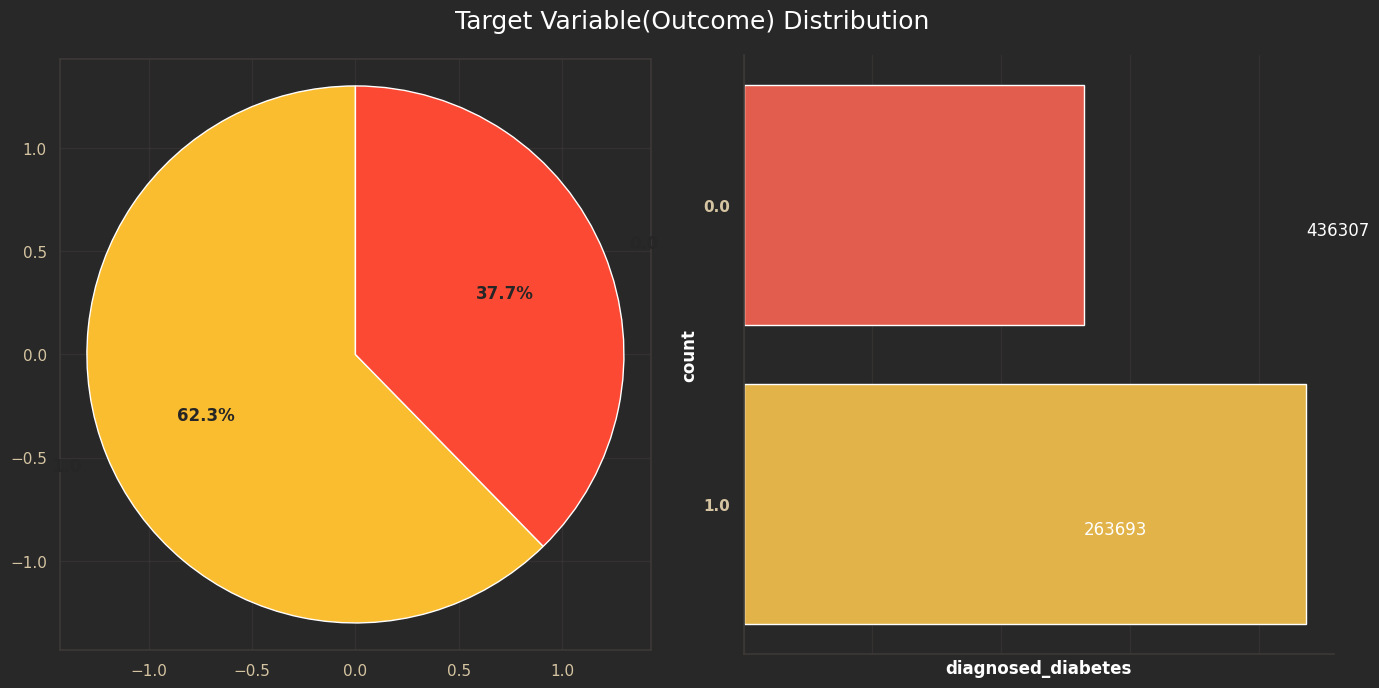

In [7]:
f, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.subplots_adjust(wspace=0.2)

s1 = target_col.value_counts()
labels = s1.index.tolist()
sizes = s1.values
N = len(s1)

ax[0].pie(
    sizes,
    labels=labels,
    startangle=90, frame=True, radius=1.3,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 12, 'weight': 'bold'},
    autopct='%1.1f%%',
    colors=[gruvbox_colors[1], gruvbox_colors[0]]
)

sns.barplot(
    x=s1.values,           
    y=list(s1.index),     
    ax=ax[1],
    orient='h',           
)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].tick_params(
    axis='x',
    which='both',
    bottom=False,
    labelbottom=False
)

for i, v in enumerate(s1):
    ax[1].text(v, i+0.1, str(v), color='white', fontsize=12)

plt.setp(ax[1].get_yticklabels(), fontweight="bold")
plt.setp(ax[1].get_xticklabels(), fontweight="bold")
ax[1].set_xlabel(target, fontweight="bold", color='white')
ax[1].set_ylabel('count', fontweight="bold", color='white')

f.suptitle('Target Variable(Outcome) Distribution', fontsize=18, color='white')
plt.tight_layout()
plt.show()

### Categorical Variables

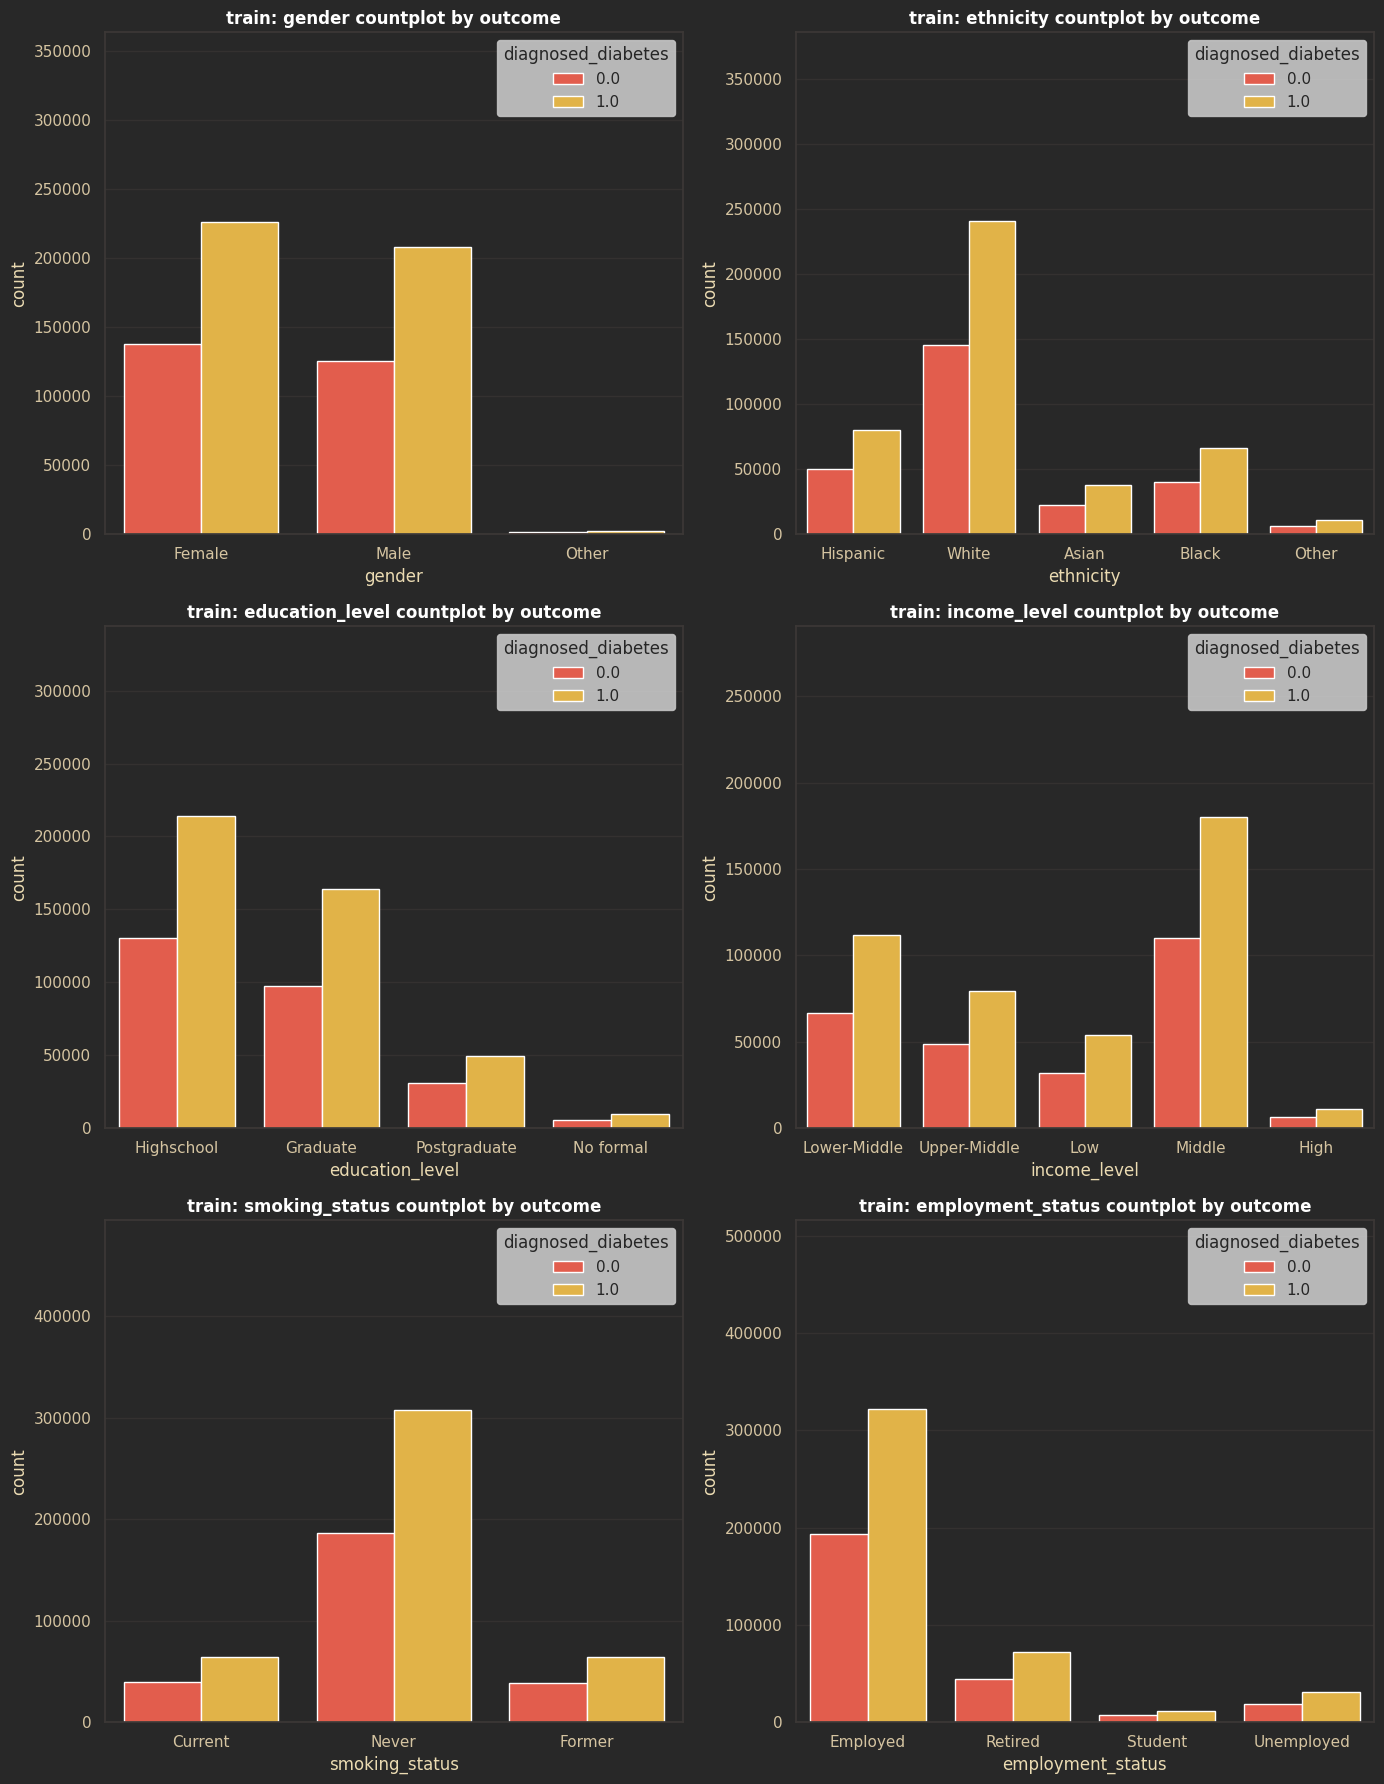

In [8]:
plt.figure(figsize=(14, len(cat_cols)*3))

for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=train)
    plt.title(f"train: {col} countplot by outcome", fontweight = 'bold', color='white')
    plt.ylim(0, train[col].value_counts().max() + 10)

plt.tight_layout()
plt.show()

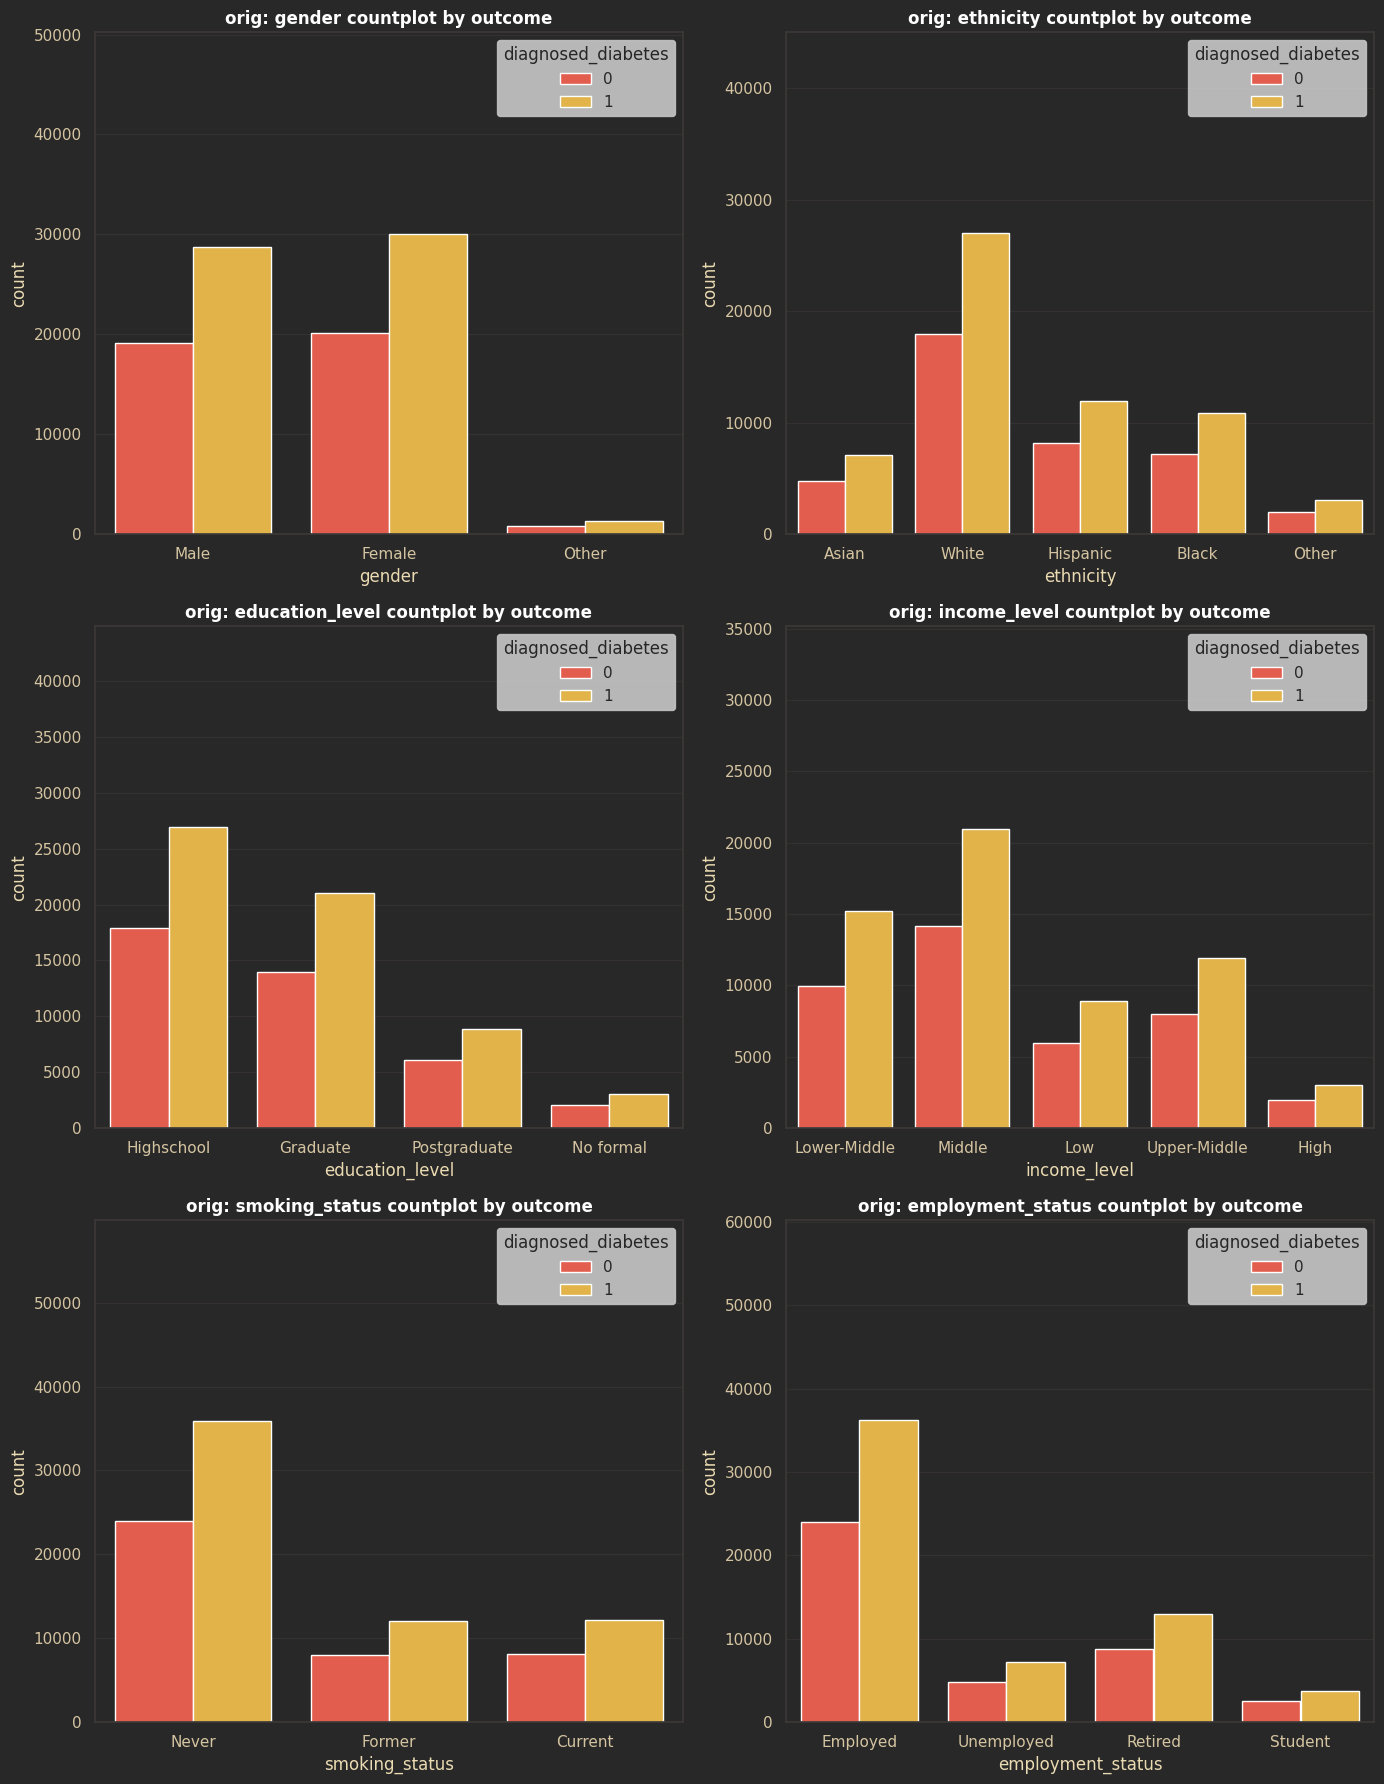

In [9]:
plt.figure(figsize=(14, len(cat_cols)*3))

for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=orig)
    plt.title(f"orig: {col} countplot by outcome", fontweight = 'bold', color='white')
    plt.ylim(0, orig[col].value_counts().max() + 10)

plt.tight_layout()
plt.show()

### Numeric Variables

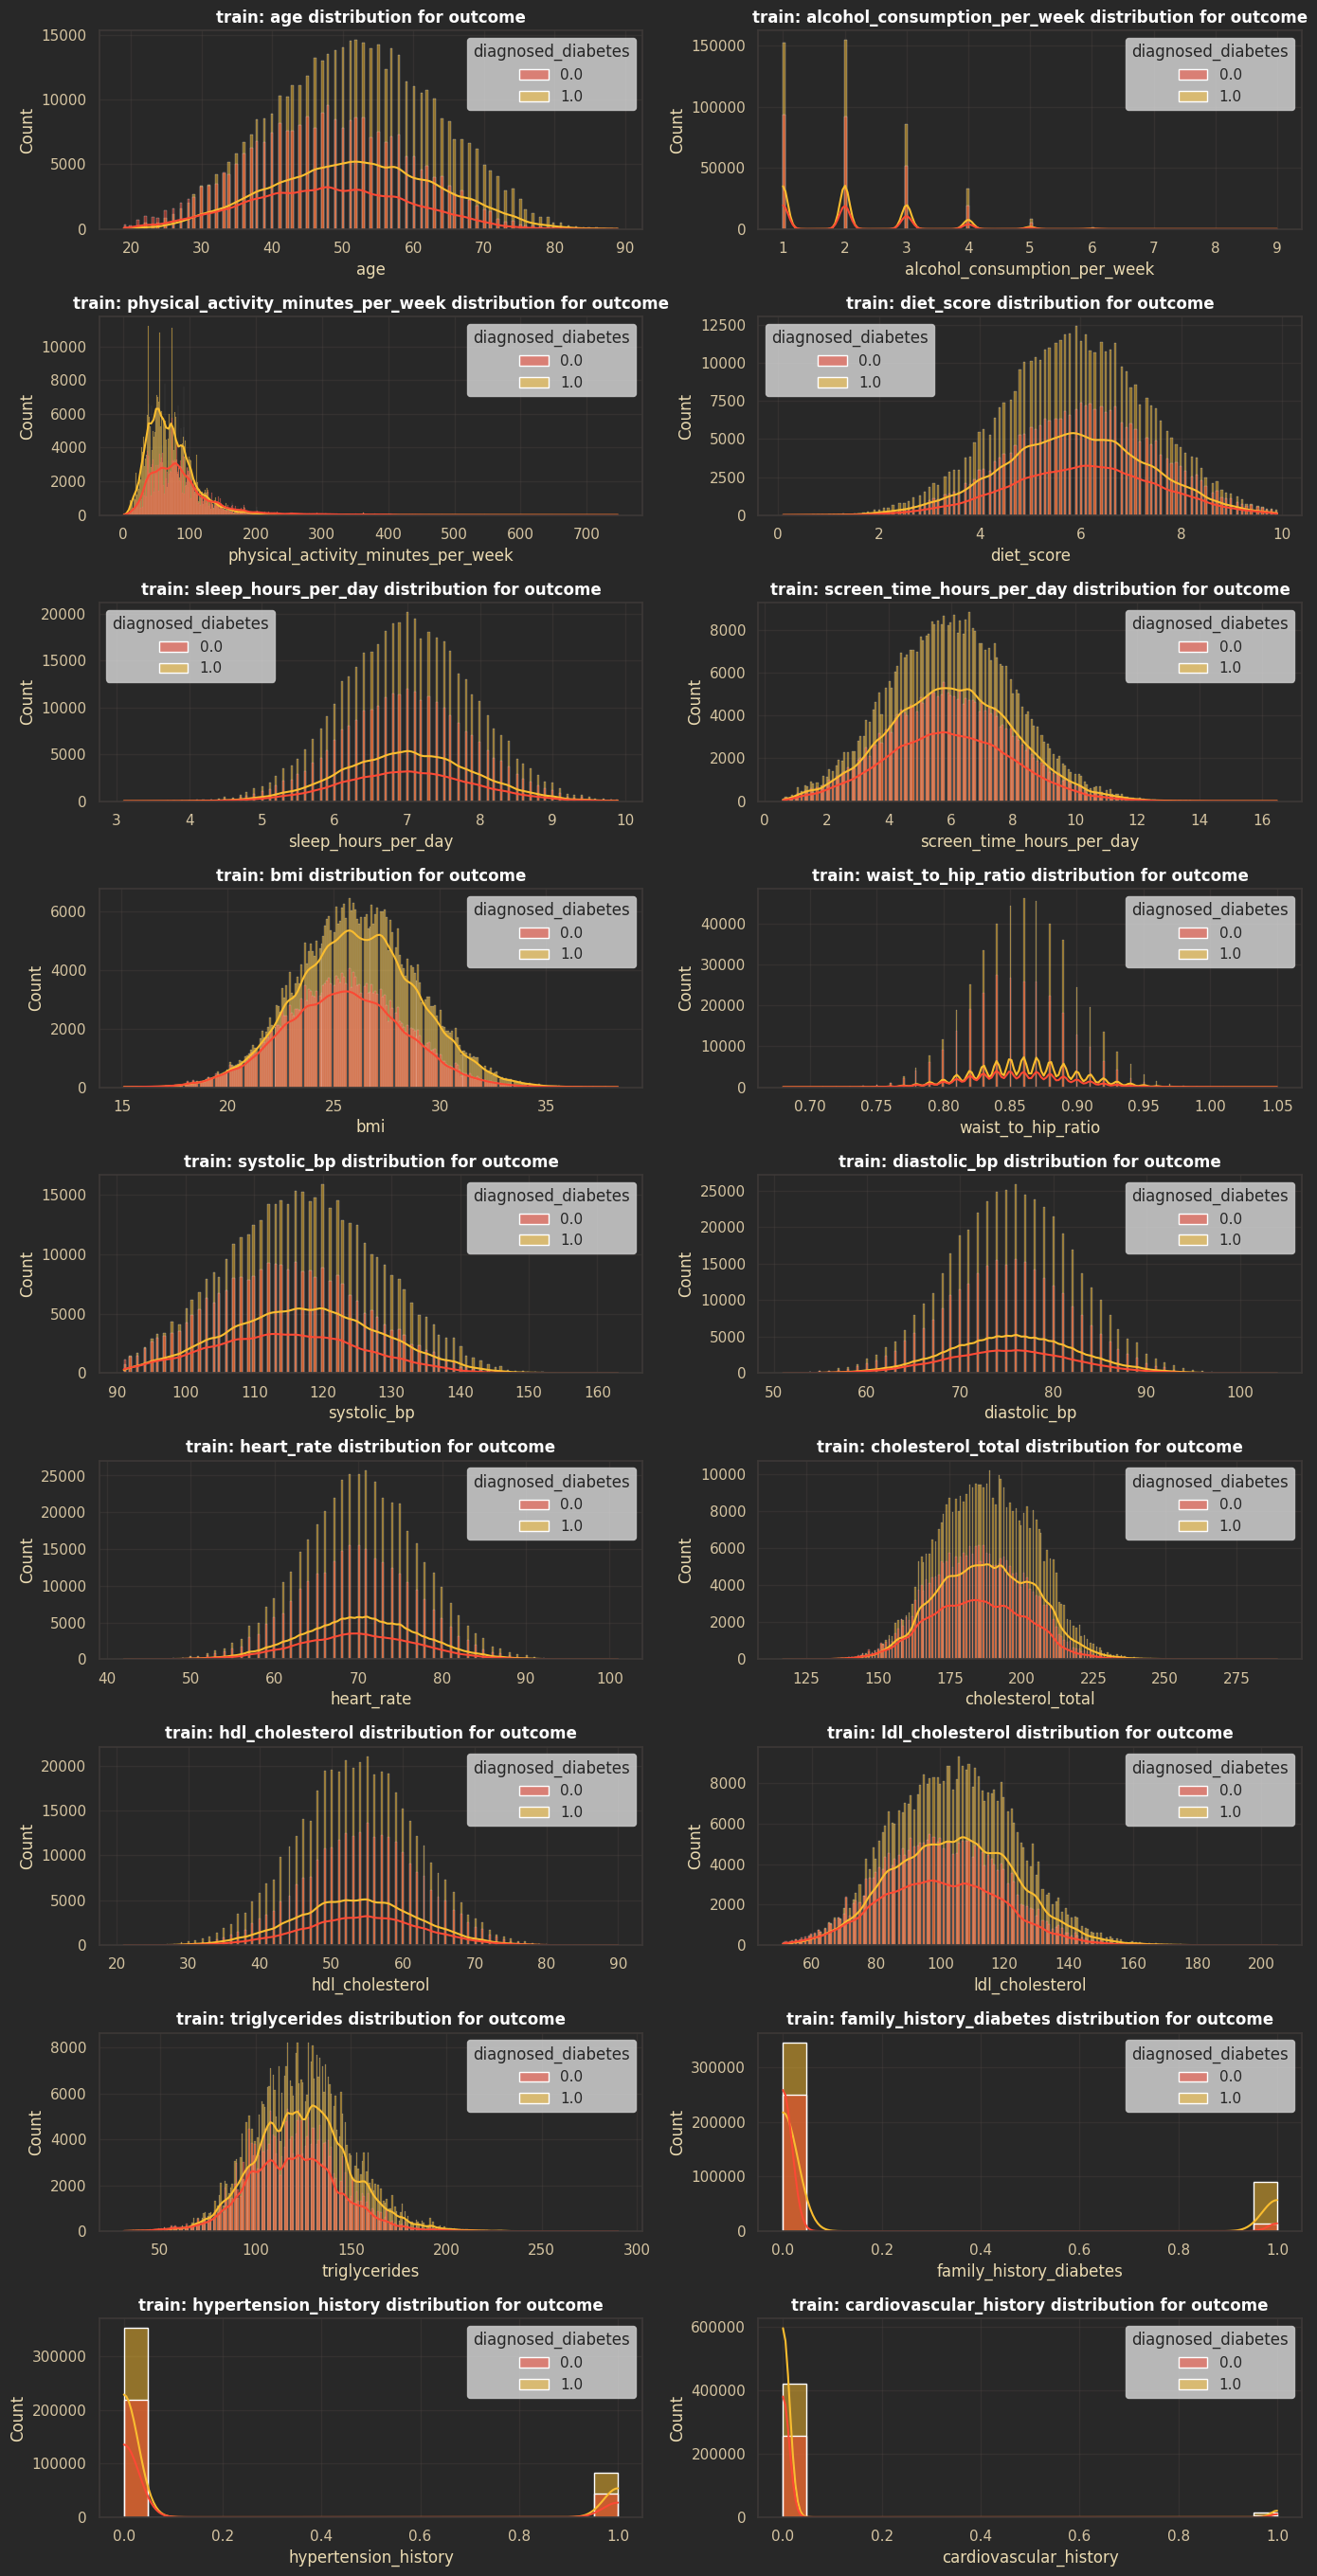

In [10]:
plt.figure(figsize=(14, len(num_cols) * 3))

for i, col in enumerate(num_cols):
    # Plotting for outcome
    plt.subplot(len(num_cols), 2, i+1)
    sns.histplot(x=col, hue=target, data=train, kde=True)
    plt.title(f"train: {col} distribution for outcome", fontweight="bold", color='white')

plt.tight_layout()
plt.show()

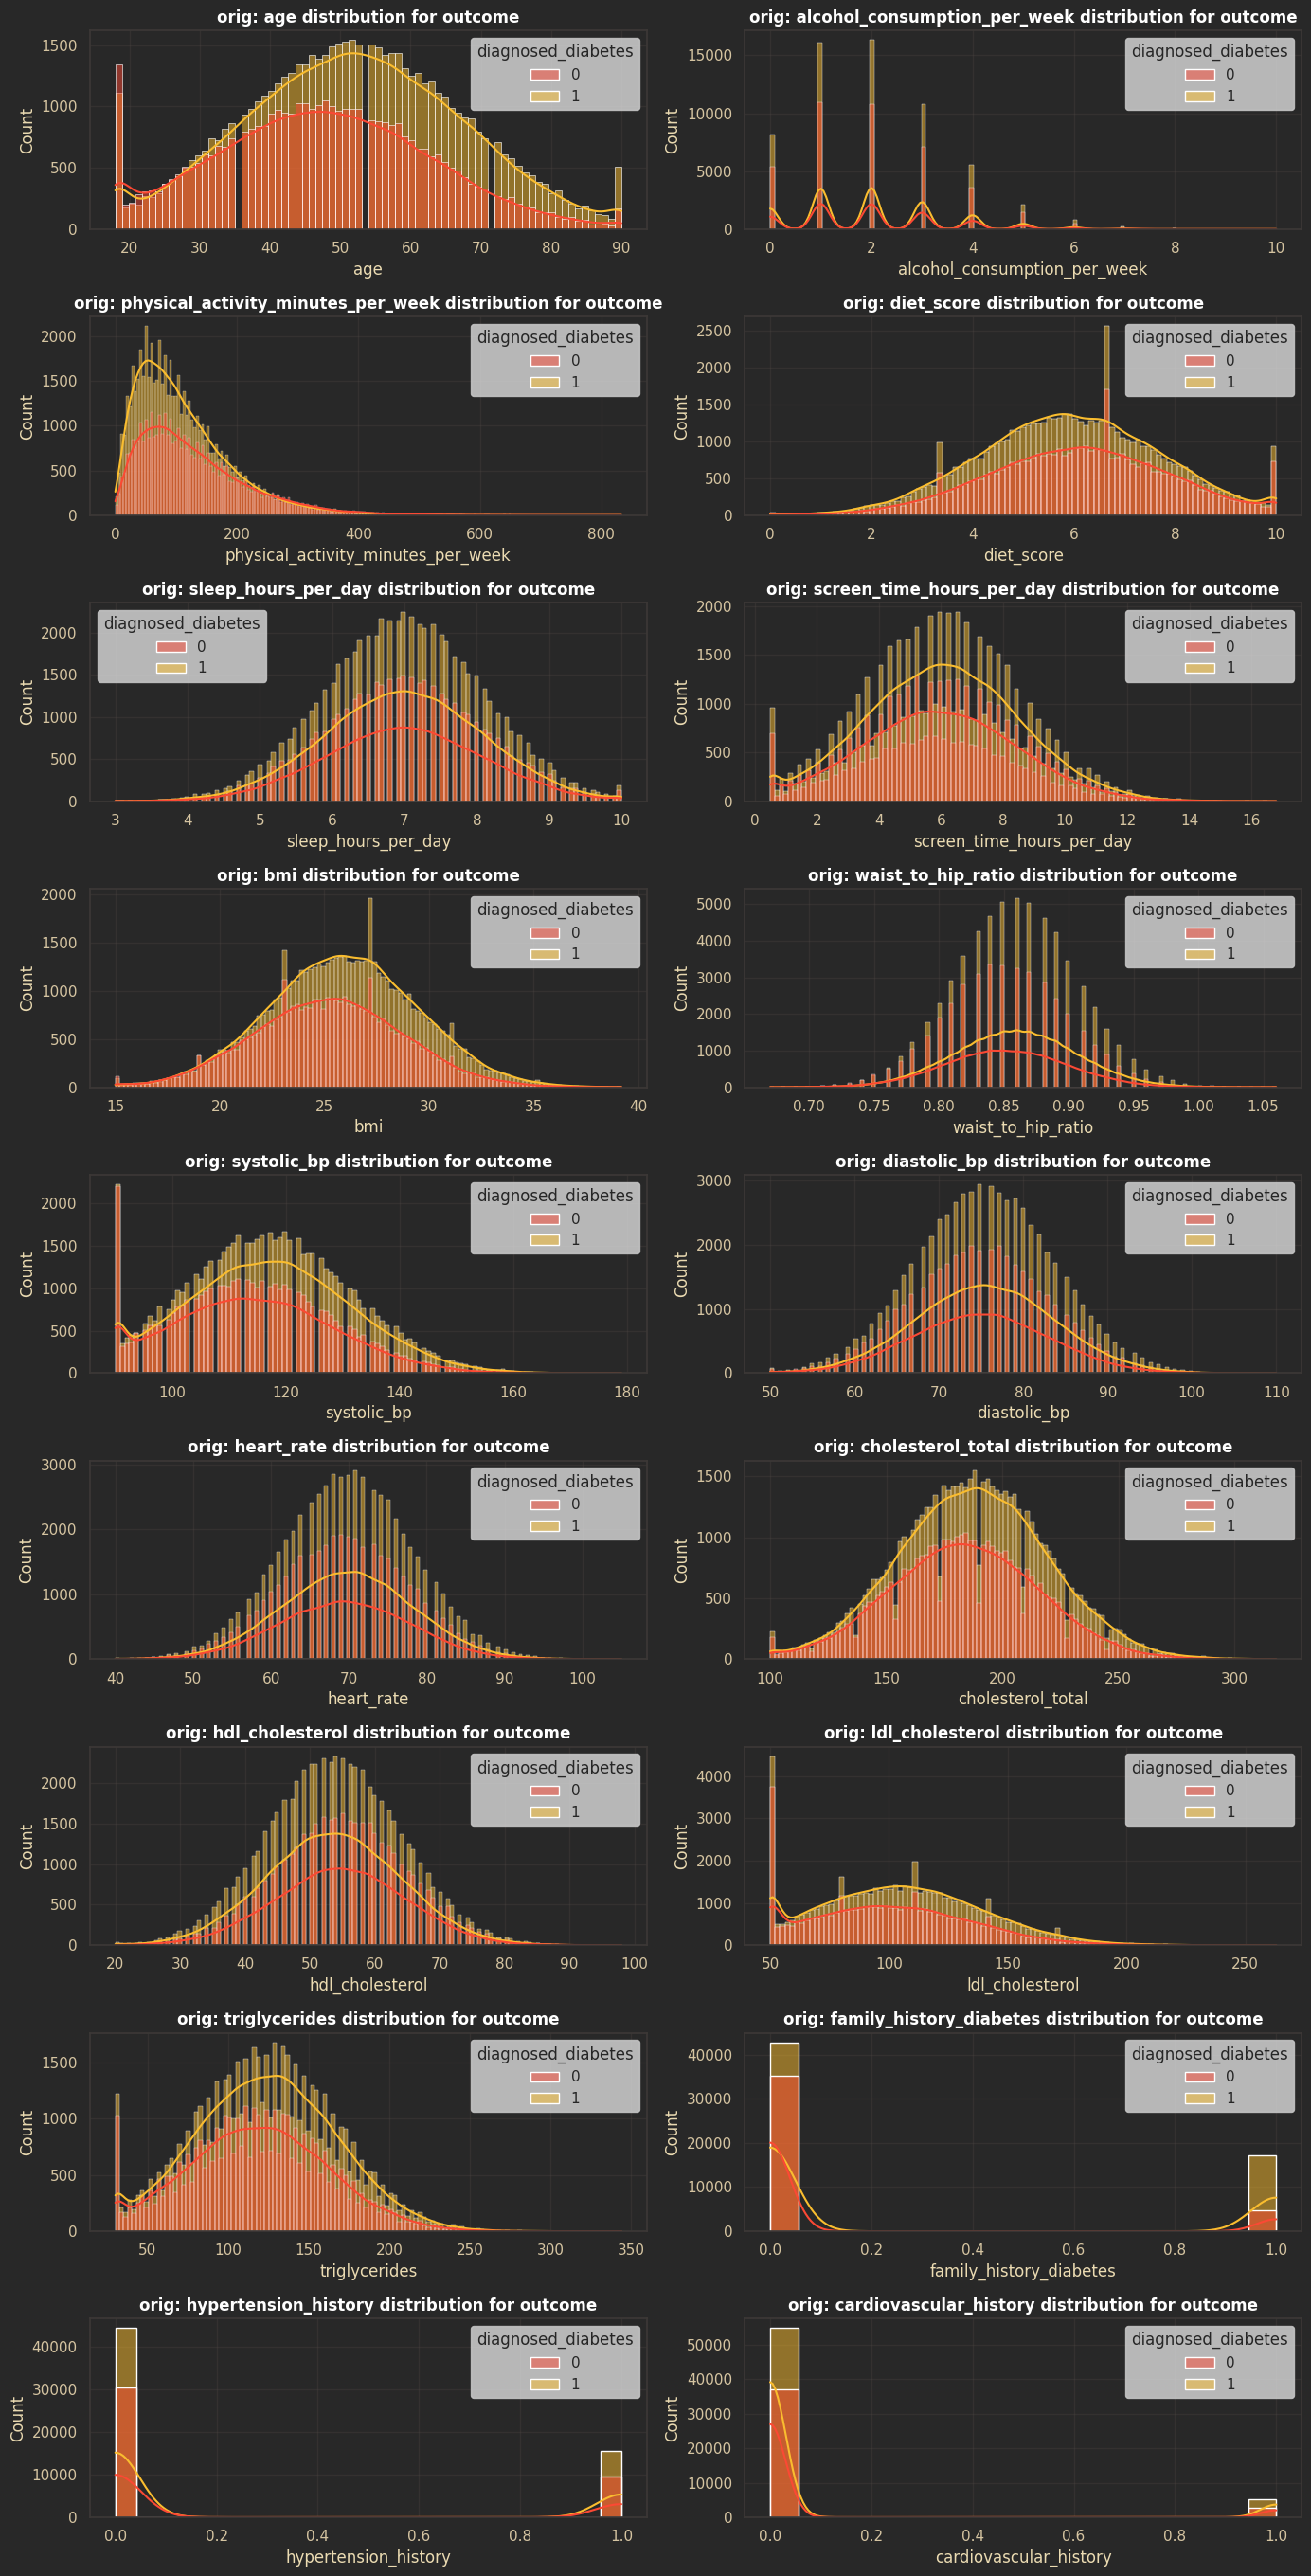

In [11]:
plt.figure(figsize=(14, len(num_cols) * 3))

for i, col in enumerate(num_cols):
    # Plotting for outcome
    plt.subplot(len(num_cols), 2, i+1)
    sns.histplot(x=col, hue=target, data=orig, kde=True)
    plt.title(f"orig: {col} distribution for outcome", fontweight="bold", color='white')

plt.tight_layout()
plt.show()

### Correlation Heatmap

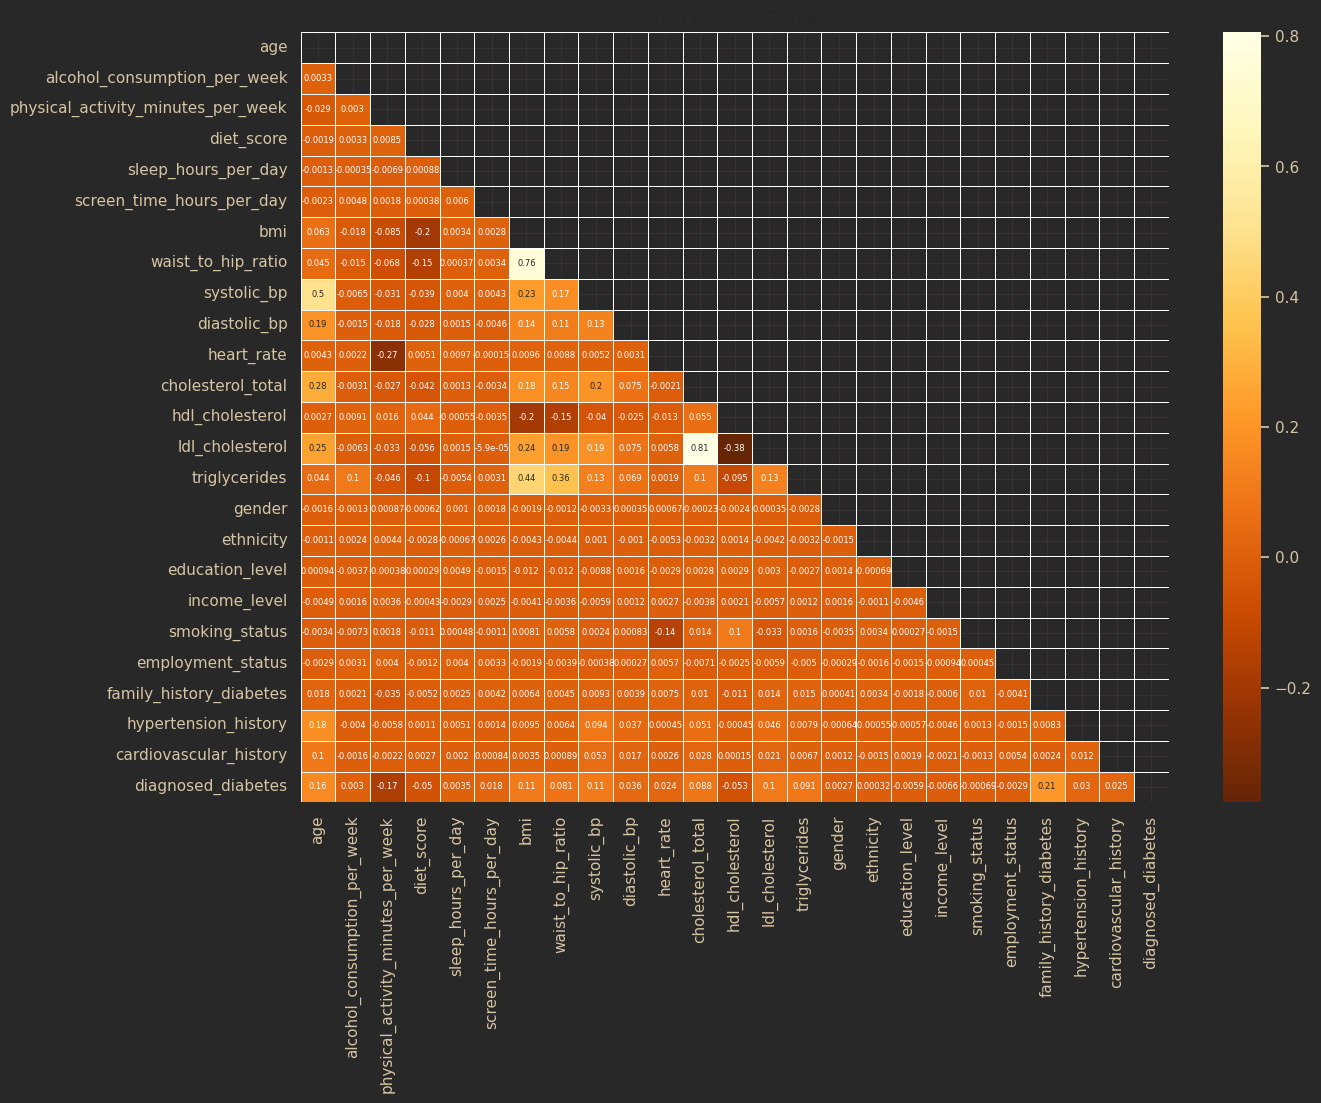

In [12]:
# Create a copy of the dataframe
df_encoded = train.copy()

# List of categorical variables (remove 'age' if it's numeric)
categorical_vars = train.select_dtypes('object').columns.to_list()

# Label encode categorical columns
label_encoders = {}
for column in categorical_vars:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le

def plot_correlation_heatmap(df: pd.DataFrame, title_name: str = 'Train correlation') -> None:
    excluded_columns = ['id']
    columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
    corr = df[columns_without_excluded].corr()
    
    plt.figure(figsize=(14, 10))
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True, annot_kws={"size": 6})
    plt.title(title_name)
    plt.show()

# Plot correlation heatmap for encoded dataframe
plot_correlation_heatmap(df_encoded, 'Encoded Dataset Correlation')

## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Feature Engineering</p>

In [13]:
#  Remove the top 50 extreme values per column based on quantile thresholds.

def remove_top50_outliers_quantile(df, low_q=0.01, high_q=0.99):
    
    df_clean = df.copy()
    cols = df_clean.select_dtypes(include=["int", "float"]).columns
    
    for col in cols:
        q_low = df_clean[col].quantile(low_q)
        q_high = df_clean[col].quantile(high_q)
        
        # Get outlier indices below low quantile and above high quantile
        outliers_below = df_clean[df_clean[col] < q_low].index
        outliers_above = df_clean[df_clean[col] > q_high].index
        
        # Combine all outliers
        outliers = list(outliers_below) + list(outliers_above)
        
        # Keep only the first 50 outliers (if available)
        outliers_to_remove = outliers[:50]
        
        # Drop these rows
        df_clean.drop(outliers_to_remove, inplace=True)
    
    return df_clean
train = remove_top50_outliers_quantile(train)

In [14]:
# https://www.kaggle.com/code/masayakawamata/s5e12-eda-xgb-competition-starter/notebook

BASE = [col for col in train.columns if col not in ['id', target]]
CATS = train.select_dtypes('object').columns.to_list()
NUMS = [col for col in BASE if col not in CATS]

ORIG = []

for col in BASE:
    # MEAN
    mean_map = orig.groupby(col)[target].mean()
    new_mean_col_name = f"orig_mean_{col}"
    mean_map.name = new_mean_col_name
    
    train = train.merge(mean_map, on=col, how='left')
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(new_mean_col_name)

    # COUNT
    new_count_col_name = f"orig_count_{col}"
    count_map = orig.groupby(col).size().reset_index(name=new_count_col_name)
    
    train = train.merge(count_map, on=col, how='left')
    test = test.merge(count_map, on=col, how='left')
    ORIG.append(new_count_col_name)

print(f'{len(ORIG)} ORIG Features Created.')

48 ORIG Features Created.


In [15]:
for col in ORIG:
    if 'mean' in col:
        train[col] = train[col].fillna(orig[target].mean())
        test[col] = test[col].fillna(orig[target].mean())
    else:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

In [16]:
class TargetEncoderOOF:
    """
    Encodes categorical features using the target mean, but uses K-Fold 
    logic to prevent data leakage in the training set.
    """
    def __init__(self, n_splits=5, smooth=10, random_state=42):
        self.n_splits = n_splits
        self.smooth = smooth
        self.random_state = random_state
        self.map_dict = {} # Stores global means for Test set

    def fit_transform(self, X, y, cat_cols):
        # We must copy to avoid modifying original dataframe in place unexpectedly
        X_encoded = X.copy()
        
        # Determine if target is continuous or binary for splitting
        if y.nunique() > 20: 
            kf = KFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        else:
            kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        for col in cat_cols:
            # 1. Calculate Global Mean (for the Test Set later)
            global_mean = y.mean()
            agg = X.groupby(col)[y.name].agg(['count', 'mean'])
            counts = agg['count']
            means = agg['mean']
            
            # Smoothing (Bayesian): (mean * count + global * smooth) / (count + smooth)
            smooth_mean = (means * counts + global_mean * self.smooth) / (counts + self.smooth)
            self.map_dict[col] = smooth_mean

            # 2. OOF Encoding for Train Set (The Anti-Leakage part)
            # Initialize with global mean as fallback
            X_encoded[f"TE_{col}"] = np.nan 
            
            for train_idx, val_idx in kf.split(X, y):
                X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_tr = y.iloc[train_idx]
                
                # Compute means on 'inner' train fold only
                fold_agg = X_tr.groupby(col)[y.name].agg(['count', 'mean'])
                fold_counts = fold_agg['count']
                fold_means = fold_agg['mean']
                
                # Smooth
                fold_smooth = (fold_means * fold_counts + global_mean * self.smooth) / (fold_counts + self.smooth)
                
                # Map to 'inner' validation fold
                X_encoded.loc[val_idx, f"TE_{col}"] = X_val[col].map(fold_smooth)
            
            # Fill remaining NaNs (unseen categories in folds) with global mean
            X_encoded[f"TE_{col}"] = X_encoded[f"TE_{col}"].fillna(global_mean)
            
        return X_encoded

    def transform(self, X_test, cat_cols):
        X_test_encoded = X_test.copy()
        for col in cat_cols:
            if col in self.map_dict:
                # Map using the global smoothed means computed in fit()
                X_test_encoded[f"TE_{col}"] = X_test_encoded[col].map(self.map_dict[col])
                # Fill new unseen categories with overall global mean
                X_test_encoded[f"TE_{col}"] = X_test_encoded[f"TE_{col}"].fillna(self.map_dict[col].mean())
        return X_test_encoded

In [17]:
BASE = [col for col in train.columns if col not in ['id', target]]
CATS = train.select_dtypes('object').columns.to_list()
NUMS = [col for col in BASE if col not in CATS]

ORIG = []

### Creating Medical Features:

Core Ideas:

- Medical Ratios: Ratios like Cholesterol/HDL are often stronger predictors than raw values.

- Risk Grouping: Binning continuous variables (like Age or BMI) into standard medical risk categories helps tree models find "step" functions.

- Interaction Flags: Combinations of conditions (e.g., "Smoker + High BP") are disproportionately risky.

In [18]:
# def create_medical_features(df):
#     df = df.copy()
    
#     # --- 1. Key Medical Ratios (High Signal) ---
#     # Atherogenic Index of Plasma (proxy): Log(Triglycerides / HDL)
#     # Note: Adding small epsilon to avoid division by zero if any 0s exist
#     df['lipid_ratio'] = df['cholesterol_total'] / (df['hdl_cholesterol'] + 1e-5)
#     df['tg_hdl_ratio'] = df['triglycerides'] / (df['hdl_cholesterol'] + 1e-5)
#     df['ldl_hdl_ratio'] = df['ldl_cholesterol'] / (df['hdl_cholesterol'] + 1e-5)
    
#     # Pulse Pressure: Strong indicator of arterial stiffness
#     df['pulse_pressure'] = df['systolic_bp'] - df['diastolic_bp']
    
#     # Mean Arterial Pressure (MAP): Average pressure in a patient's arteries
#     df['map_pressure'] = df['diastolic_bp'] + (df['pulse_pressure'] / 3)
    
#     # BMI-Waist Interaction (Visceral Fat Proxy)
#     df['bmi_waist_interaction'] = df['bmi'] * df['waist_to_hip_ratio']

#     # --- 2. Lifestyle Composite Scores ---
#     # Combine individual "bad habits" into a single risk score
#     # Normalize inputs roughly so one doesn't dominate
#     df['lifestyle_risk_score'] = (
#         (df['alcohol_consumption_per_week'] / 9.0) + # Normalized by max
#         (df['screen_time_hours_per_day'] / 16.0) -  # Normalized by max
#         (df['physical_activity_minutes_per_week'] / 750.0) - 
#         (df['sleep_hours_per_day'] / 10.0)
#     )
    
#     # --- 3. Metabolic Syndrome Flags (Boolean) ---
#     # These mimic real diagnostic criteria
#     # High BP flag
#     df['high_bp_flag'] = ((df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 85)).astype(int)
    
#     # High Triglycerides flag
#     df['high_tg_flag'] = (df['triglycerides'] >= 150).astype(int)
    
#     # Low HDL flag
#     # (Usually <40 for men, <50 for women, taking generic 45 here as compromise or if gender not encoded yet)
#     df['low_hdl_flag'] = (df['hdl_cholesterol'] < 45).astype(int)
    
#     # Obesity flag
#     df['obesity_flag'] = (df['bmi'] >= 30).astype(int)
    
#     # Count how many metabolic risk factors the person has (0-4)
#     df['metabolic_risk_count'] = (
#         df['high_bp_flag'] + 
#         df['high_tg_flag'] + 
#         df['low_hdl_flag'] + 
#         df['obesity_flag'] + 
#         df['hypertension_history']
#     )
    
#     # --- 4. Binning (Helping Trees finding thresholds) ---
#     # Age Groups (Standard Medical)
#     df['age_group'] = pd.cut(
#         df['age'], 
#         bins=[0, 35, 50, 65, 100], 
#         labels=[0, 1, 2, 3] # Young, Middle, Senior, Elderly
#     ).astype(int)
    
#     return df

# # --- APPLY IT ---
# print("Creating medical features...")
# train = create_medical_features(train)
# test = create_medical_features(test)

# # Update lists so the pipeline knows about them
# BASE = [col for col in train.columns if col not in ['id', target]]
# CATS = train.select_dtypes('object').columns.to_list()
# NUMS = [col for col in BASE if col not in CATS]

# ORIG = []

# print("Done")

In [19]:
train

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,orig_mean_smoking_status,orig_count_smoking_status,orig_mean_employment_status,orig_count_employment_status,orig_mean_family_history_diabetes,orig_count_family_history_diabetes,orig_mean_hypertension_history,orig_count_hypertension_history,orig_mean_cardiovascular_history,orig_count_cardiovascular_history
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,0.600069,20176,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,0.599569,59813,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,0.599569,59813,0.595285,21761,0.548572,78059,0.592178,74920,0.595699,92080
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,0.600069,20176,0.601512,60175,0.548572,78059,0.623285,25080,0.595699,92080
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,0.599569,59813,0.595285,21761,0.548572,78059,0.623285,25080,0.595699,92080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699245,29,1,59,6.9,5.2,1.5,26.1,0.88,133,57,...,0.601119,20011,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
699246,46,2,72,7.7,7.7,3.8,25.5,0.85,106,85,...,0.601119,20011,0.601512,60175,0.548572,78059,0.592178,74920,0.649747,7920
699247,35,1,50,5.6,6.1,6.4,26.9,0.88,127,84,...,0.599569,59813,0.601512,60175,0.548572,78059,0.592178,74920,0.595699,92080
699248,49,2,70,5.7,6.9,4.7,25.2,0.86,116,67,...,0.599569,59813,0.595285,21761,0.548572,78059,0.592178,74920,0.595699,92080


In [20]:
te_cols = CATS  
# If later create interaction columns (like 'gender_smoking_combo'), add them:
# te_cols = CATS + ['gender_smoking_combo', 'age_group_cardio_combo']

encoder = TargetEncoderOOF(n_splits=5, smooth=10, random_state=42)

print("Starting Target Encoding (OOF)...")

# Fit & Transform TRAIN (This generates 'TE_' columns without leakage)
# Note: We pass the whole train dataframe and the target series
train = encoder.fit_transform(train, train[target], te_cols)

# 4. Transform TEST (This uses the safe values learned from Train)
test = encoder.transform(test, te_cols)

print("Target Encoding Done.")
print(f"New columns created: {[col for col in train.columns if 'TE_' in col]}")

Starting Target Encoding (OOF)...
Target Encoding Done.
New columns created: ['TE_gender', 'TE_ethnicity', 'TE_education_level', 'TE_income_level', 'TE_smoking_status', 'TE_employment_status']


In [21]:
df_encoded = train.copy()
df_test_encoded = test.copy()

# List of categorical variables
categorical_vars = CATS

# Label encode categorical columns
label_encoders = {}
for column in categorical_vars:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le
    
# Label encode categorical columns
label_encoders = {}
for column in categorical_vars:
    le = LabelEncoder()
    df_test_encoded[column] = le.fit_transform(df_test_encoded[column].astype(str))
    label_encoders[column] = le

In [22]:
df_onehot = df_encoded.copy()
df_test_onehot = df_test_encoded.copy()

for column in cat_cols:
    dummies = pd.get_dummies(df_encoded[column], prefix=column, drop_first=True)
    df_onehot = pd.concat([df_onehot, dummies], axis=1)
    df_onehot.drop(column, axis=1, inplace=True)

# now replace false for 1 and true for 0 in the target column
for column in df_onehot.select_dtypes(include=['bool']).columns:
    df_onehot[column] = df_onehot[column].astype(int)
    
# same for test set
for column in cat_cols:
    dummies = pd.get_dummies(df_test_onehot[column], prefix=column, drop_first=True)
    df_test_onehot = pd.concat([df_test_onehot, dummies], axis=1)
    df_test_onehot.drop(column, axis=1, inplace=True)

for column in df_test_onehot.select_dtypes(include=['bool']).columns:
    df_test_onehot[column] = df_test_onehot[column].astype(int)

df_onehot.head()

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,education_level_3,income_level_1,income_level_2,income_level_3,income_level_4,smoking_status_1,smoking_status_2,employment_status_1,employment_status_2,employment_status_3
0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,70,...,0,0,1,0,0,0,0,0,0,0
1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,77,...,0,0,0,0,1,0,1,0,0,0
2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,89,...,0,0,1,0,0,0,1,1,0,0
3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,69,...,0,0,1,0,0,0,0,0,0,0
4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,60,...,0,0,0,0,1,0,1,1,0,0


In [23]:
y_train = df_onehot[target]
X_train = df_onehot.drop(columns=[target])
X_test = df_test_onehot.copy()

In [24]:
def memory_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / 1024**2
    
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
    return df

print("Train memory BEFORE:", f"{memory_mb(X_train):.2f} MB")
print("Test  memory BEFORE:", f"{memory_mb(X_test):.2f} MB")

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)


print("Train memory AFTER: ", f"{memory_mb(X_train):.2f} MB")
print("Test  memory AFTER: ", f"{memory_mb(X_test):.2f} MB")

gc.collect()

Train memory BEFORE: 480.14 MB
Test  memory BEFORE: 205.99 MB
Train memory AFTER:  156.04 MB
Test  memory AFTER:  66.95 MB


526868

## <p style="font-family: Georgia; font-weight: normal; letter-spacing: 2px; color: #fabd2f;     font-size: 140%; text-align: left; padding: 0px; border-bottom: 3px solid #fabd2f;">Models</p>

In [25]:
class Splitter:
    def __init__(self, n_splits=5, cat_df=pd.DataFrame(), test_size=0.2):
        self.n_splits = n_splits
        self.cat_df = cat_df
        self.test_size = test_size

    def split_data(self, X, y, random_state_list):
        for random_state in random_state_list:
            kf = KFold(
                n_splits=self.n_splits,
                random_state=random_state,
                shuffle=True
            )
            for train_index, val_index in kf.split(X, y):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                yield X_train, X_val, y_train, y_val, val_index, random_state

In [26]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=100):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the score for the weighted prediction
        score = roc_auc_score(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.TPESampler(seed=self.random_state)
        pruner = optuna.pruners.MedianPruner()
        self.study = optuna.create_study(
            sampler=sampler,
            pruner=pruner,
            study_name="OptunaWeights",
            direction="maximize",
        )
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

In [27]:
def binary_focal_loss(alpha=0.8, gamma=2.0):
    """
    Binary focal loss for imbalanced classification.
    y_true: (batch, 1) or (batch,) with 0/1 labels
    y_pred: (batch, 1) probabilities after sigmoid
    """
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Clip to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # p_t: prob of the true class
        p_t = tf.where(tf.equal(y_true, 1.0), y_pred, 1.0 - y_pred)

        # alpha_t: alpha for positive, 1 - alpha for negative
        alpha_t = tf.where(tf.equal(y_true, 1.0), alpha, 1.0 - alpha)

        # focal loss
        loss_val = -alpha_t * tf.pow(1.0 - p_t, gamma) * tf.math.log(p_t)
        return tf.reduce_mean(loss_val)
    return loss

In [28]:
# V2
class KerasTabularMLP2:

    def __init__(
        self,
        input_dim,
        random_state=42,
        hidden_units=(512, 512, 256, 128),
        learning_rate=1e-4,
    ):
        self.input_dim = input_dim
        self.random_state = random_state
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate

        # store init params for cloning
        self._init_params = dict(
            input_dim=input_dim,
            random_state=random_state,
            hidden_units=hidden_units,
            learning_rate=learning_rate,
        )

        self.model = self._build_model()

    def _build_model(self):
        tf.keras.utils.set_random_seed(self.random_state)

        inputs = keras.Input(shape=(self.input_dim,), dtype="float32")

        # ---- Wide (linear) part: FM-style linear term ----
        wide_logit = layers.Dense(
            1,
            use_bias=True,
            name="wide_logit"
        )(inputs)

        # ---- Deep part: bigger residual MLP ----
        x = layers.BatchNormalization()(inputs)

        h = x
        for i, units in enumerate(self.hidden_units):
            h_prev = h

            h = layers.Dense(
                units,
                activation="relu",
                kernel_initializer="he_normal"
            )(h)
            h = layers.BatchNormalization()(h)
            # stronger dropout on early layers, a bit lighter later
            drop_rate = 0.3 if i < 2 else 0.1
            h = layers.Dropout(drop_rate)(h)

            # Residual connection when dimensions match
            if h.shape[-1] == h_prev.shape[-1]:
                h = layers.Add()([h_prev, h])

        deep_logit = layers.Dense(
            1,
            use_bias=False,
            name="deep_logit"
        )(h)

        # ---- Combine wide + deep logits ----
        logits = layers.Add(name="combined_logit")([wide_logit, deep_logit])
        outputs = layers.Activation("sigmoid", name="prediction")(logits)

        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss="binary_crossentropy",
            metrics=[keras.metrics.AUC(name="auc")],
        )
        return model

    def fit(self, X_train, y_train, X_val=None, y_val=None,
            epochs=300, batch_size=512):
        X_train = np.asarray(X_train, dtype="float32")
        y_train = np.asarray(y_train, dtype="float32")

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_auc",
                mode="max",
                patience=6,
                restore_best_weights=True,
                verbose=0,
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_auc",
                mode="max",
                factor=0.5,
                patience=3,
                min_lr=1e-6,
                verbose=0,
            ),
        ]

        if X_val is not None and y_val is not None:
            X_val = np.asarray(X_val, dtype="float32")
            y_val = np.asarray(y_val, dtype="float32")
            self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=0,
            )
        else:
            self.model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=0,
            )

    def predict_proba(self, X):
        X = np.asarray(X, dtype="float32")
        probs_pos = self.model.predict(X, batch_size=512, verbose=0).ravel()
        probs_neg = 1.0 - probs_pos
        return np.vstack([probs_neg, probs_pos]).T

    def clone(self):
        """Create a fresh, untrained copy with same hyperparams."""
        return self.__class__(**self._init_params)

    def __deepcopy__(self, memo):
        # copy.deepcopy(self) will call this
        return self.clone()

In [29]:
# V3
class KerasTabularMLP3:
    def __init__(self, input_dim, random_state=42, alpha=0.7, gamma=2.0, lr=1e-3):
        self.input_dim = input_dim
        self.random_state = random_state
        self.alpha = alpha
        self.gamma = gamma
        self.lr = lr

        # store init params for cloning
        self._init_params = dict(
            input_dim=input_dim,
            random_state=random_state,
            alpha=alpha,
            gamma=gamma,
            lr=lr,
        )

        # important: make sure the attribute exists
        # build immediately (eager) OR set to None and build lazily in fit
        self.model = self._build_model()

    def _build_model(self):
        tf.keras.utils.set_random_seed(self.random_state)

        inputs = keras.Input(shape=(self.input_dim,), dtype="float32")
        x = layers.BatchNormalization()(inputs)

        h1 = layers.Dense(256, activation="relu", kernel_initializer="he_normal")(x)
        h1 = layers.BatchNormalization()(h1)
        h1 = layers.Dropout(0.2)(h1)

        h2 = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(h1)
        h2 = layers.BatchNormalization()(h2)
        h2 = layers.Dropout(0.2)(h2)

        h2 = layers.Concatenate()([h1, h2])

        h3 = layers.Dense(64, activation="relu", kernel_initializer="he_normal")(h2)
        h3 = layers.BatchNormalization()(h3)
        h3 = layers.Dropout(0.1)(h3)

        outputs = layers.Dense(1, activation="sigmoid")(h3)

        model = keras.Model(inputs=inputs, outputs=outputs)

        fl = binary_focal_loss(alpha=self.alpha, gamma=self.gamma)

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.lr),
            loss=fl,
            metrics=[keras.metrics.AUC(name="auc")],
        )
        return model

    def fit(
        self,
        X_train,
        y_train,
        X_val=None,
        y_val=None,
        epochs=100,
        batch_size=512,
    ):
        # safety: if for some reason model is None, rebuild it
        if self.model is None:
            self.model = self._build_model()

        X_train = np.asarray(X_train, dtype="float32")
        y_train = np.asarray(y_train, dtype="float32")

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_auc",
                mode="max",
                patience=5,
                restore_best_weights=True,
                verbose=0,
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_auc",
                mode="max",
                factor=0.5,
                patience=3,
                min_lr=1e-5,
                verbose=0,
            ),
        ]

        if X_val is not None and y_val is not None:
            X_val = np.asarray(X_val, dtype="float32")
            y_val = np.asarray(y_val, dtype="float32")
            self.model.fit(
                X_train,
                y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=0,
            )
        else:
            self.model.fit(
                X_train,
                y_train,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=0,
            )

        return self  # sklearn-style

    def predict_proba(self, X):
        if self.model is None:
            raise RuntimeError("Model is not trained. Call fit() first.")

        X = np.asarray(X, dtype="float32")
        probs_pos = self.model.predict(X, batch_size=4096, verbose=0).ravel()
        probs_neg = 1.0 - probs_pos
        return np.vstack([probs_neg, probs_pos]).T

    def clone(self):
        """Create a fresh, untrained copy with same hyperparams."""
        return self.__class__(**self._init_params)

    def __deepcopy__(self, memo):
        return self.clone()

In [30]:
n_splits = 5
random_state = 42
random_state_list = [42]

n_features = X_train.shape[1]
splitter = Splitter(n_splits=n_splits, cat_df=y_train)

# For scale pos weight (class imbalance) didn't achieve meaningful results while testing with simple models
# Maybe try later again
# y_raw = y_train.copy()
# y_model = (y_train == 0).astype(int)
# pos = y_model.sum()       
# neg = len(y_model) - pos   
# spw = neg / pos            

# Optimize params later
base_models = {

    # Testing Tabular NNs since dataset pretty large    
    "keras_mlp3": KerasTabularMLP3(
        input_dim=n_features,
        random_state=random_state,
        alpha=0.7,
        gamma=2.0,
        lr=1e-3,
    ),

    "keras_mlp2": KerasTabularMLP2(
        input_dim=n_features,
        random_state=random_state,
    ),

    # Nacked models
    "xgb_base": xgb.XGBClassifier(
        random_state=random_state,
        device="cuda",
    ),

    "lgbm_base": lgb.LGBMClassifier(
        random_state=random_state,
    ),

    # STANDARD first models, tunned manually or from different competitions
    "cat_2": CatBoostClassifier(
        iterations=3000,
        learning_rate=0.031,               
        depth=4, 
        l2_leaf_reg=10,
        border_count=500, 
        grow_policy='Depthwise',   
        eval_metric='AUC',
        early_stopping_rounds=500,
        random_seed=random_state,         
        use_best_model=True,             
        boosting_type='Plain',
        task_type="GPU",
        od_type='Iter',                   
    ),
    
    "lgbm": lgb.LGBMClassifier(
        n_estimators=600,
        learning_rate=0.03,
        subsample=0.7,
        colsample_bytree=0.7,
        max_depth=6,
        objective="binary",
        random_state=random_state,
        #scale_pos_weight=spw,
        n_jobs=-1,
    ),

    "xgb": xgb.XGBClassifier(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=5,
        objective="binary:logistic",
        device="cuda",
        tree_method="hist",
        eval_metric="aucpr",
        random_state=random_state,
        #scale_pos_weight=spw,
        n_jobs=-1,
    ),

    "cat": CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="AUC",
        iterations=600,
        learning_rate=0.03,
        depth=6,
        random_state=random_state,
        l2_leaf_reg=3,
        verbose=False,
        task_type="GPU",
    ),

    "lgbm_1": lgb.LGBMClassifier(
        objective="binary",
        metric="auc",
        max_depth=-1,
        num_leaves=127,
        learning_rate=0.005,
        n_jobs=-1,
        verbose=-1,
        n_estimators=3500,
    ),

    "xgb_1": xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        device="cuda",
        max_depth=6,
        learning_rate=0.005,
        subsample=0.8,
        reg_alpha=0.05,
        reg_lambda=0.1,
        n_estimators=3500,
        verbosity=1,
        n_jobs=-1,
    ),
    
    "cat_1": CatBoostClassifier(
        iterations=3000,
        depth=7,
        learning_rate=0.02,
        loss_function="Logloss",
        eval_metric="AUC",
        logging_level="Verbose",
        task_type="GPU",
        early_stopping_rounds=100,
        random_state=random_state,
    ),

    # --- testing more GOOD models ---
    # Good for stabilizing high-variance boosting models
    # "rf_base": RandomForestClassifier(
    #     n_estimators=300,
    #     max_depth=12,         
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     n_jobs=-1,
    #     random_state=random_state,
    # ),

    # # Extra Trees: More random than RF, often faster and less prone to overfitting
    # "et_base": ExtraTreesClassifier(
    #     n_estimators=300, 
    #     max_depth=12,
    #     min_samples_leaf=5,
    #     max_features="sqrt",
    #     n_jobs=-1,
    #     random_state=random_state,
    # ),
    
    # # LGBM with "Extra Trees" splits: Very fast, highly randomized trees
    # "lgbm_xt": lgb.LGBMClassifier(
    #     n_estimators=500,
    #     learning_rate=0.05,
    #     extra_trees=True,      # KEY: Uses randomized thresholds (like ExtraTrees)
    #     num_leaves=31,
    #     max_depth=8,
    #     objective="binary",
    #     metric="auc",
    #     random_state=random_state,
    #     n_jobs=-1,
    # ),

    # XGBoost DART: Uses dropout (randomly drops trees during training). 
    "xgb_dart": xgb.XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        booster='dart',        # KEY: DART booster
        rate_drop=0.1,
        skip_drop=0.5,
        max_depth=6,
        objective="binary:logistic",
        tree_method="hist",
        device="cuda",         # GPU
        random_state=random_state,
        n_jobs=-1,
    ),

    # Shallow CatBoost: Captures simple interactions very quickly
    "cat_shallow": CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=3,               # KEY: Very shallow
        l2_leaf_reg=5,
        loss_function="Logloss",
        eval_metric="AUC",
        verbose=False,
        task_type="GPU",       # GPU
        random_state=random_state,
    ),

    # Sklearn's Histogram Boosting: 
    # Similar to LGBM but distinct implementation details often yield different results
    "hist_grad": HistGradientBoostingClassifier(
        max_iter=400,
        learning_rate=0.05,
        max_leaf_nodes=31,
        max_depth=8,
        early_stopping=True,
        random_state=random_state,
    ),

    # --- DIVERSITY MODELS (High Randomness / Aggressive) ---
    # Aggressive XGB
    # High learning rate (0.55) + Shallow depth (3) = Fast, aggressive learner
    "xgb_aggressive": xgb.XGBClassifier(
        n_estimators=1000,
        max_depth=3,
        learning_rate=0.55, 
        min_child_weight=2,
        colsample_bytree=0.9, 
        objective="binary:logistic",  
        eval_metric="auc",           
        random_state=random_state, 
        device="cuda",
        n_jobs=-1,
    ),

    # Highly Randomized LGBM
    # Subsample 0.2 means it only sees 20% of data per tree. 
    # Great for ensemble diversity.
    "lgbm_random": lgb.LGBMClassifier(
        n_estimators=600,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.20,               # Very high randomness
        colsample_bytree=0.56,
        reg_alpha=0.25,
        reg_lambda=5e-08,
        objective="binary",           
        metric="auc",                 
        random_state=random_state,
        n_jobs=-1,
    ),

    # # Tuned CatBoost (optuna)
    # "cat_tuned": CatBoostClassifier(
    #     iterations=700,          
    #     learning_rate=0.068,
    #     depth=3,
    #     l2_leaf_reg=4.25,
    #     bagging_temperature=0.08,
    #     random_strength=6.9, 
    #     border_count=88,
    #     random_state=random_state,
    #     verbose=False,
    #     loss_function="Logloss",      
    #     eval_metric="AUC",
    #     task_type="GPU",
    # ),

    # # Sklearn HistGradient (Adapted)
    # "hist_balanced": HistGradientBoostingClassifier(
    #     l2_regularization=0.01,
    #     early_stopping=True,
    #     learning_rate=0.01,
    #     max_iter=500,
    #     max_depth=4,
    #     max_leaf_nodes=10,
    #     class_weight='balanced',      # Keeps the balanced logic
    #     random_state=random_state
    # ),
}

I0000 00:00:1765062137.810561      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765062137.811246      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [31]:
def run_cv_optuna_blend(
    X_train,
    y_train,
    X_test,
    base_models: dict,
    splitter: object, # Type hint adjusted
    random_state_list: list,
    n_splits: int,
    optuna_n_trials: int = 100,
    early_stopping_rounds: int = 200,
    verbose: bool = False,
):
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]

    # global containers
    test_predss = np.zeros(n_test)
    oof_predss = np.zeros(n_train)

    ensemble_scores = []
    weights_per_fold = []

    # per-model scores by fold
    score_dict = {name: [] for name in base_models.keys()}

    splits = splitter.split_data(X_train, y_train, random_state_list=random_state_list)

    for fold_idx, (X_tr, X_val, y_tr, y_val, val_index, seed) in enumerate(splits):
        fold_num = fold_idx % n_splits
        
        # fresh models for this fold
        models = {name: deepcopy(model) for name, model in base_models.items()}

        oof_preds_fold = []
        test_preds_fold = []

        for name, model in models.items():
            # --- training per framework ---
            
            # 1. LightGBM
            if 'lgb' in name:
                model.set_params(verbosity=-1)
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                )

            # 2. XGBoost
            elif 'xgb' in name:
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    verbose=0
                )

            # 3. CatBoost
            elif 'cat' in name:
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    use_best_model=True,
                    early_stopping_rounds=early_stopping_rounds,
                    verbose=verbose
                )
            
            # 4. Standard Sklearn (RandomForest, ExtraTrees, HistGradient)
            # These DO NOT accept eval_set or X_val in fit()
            elif any(x in name for x in ['rf', 'et', 'hist', 'forest', 'extra']):
                model.fit(X_tr, y_tr)

            # 5. Custom Keras/NN Wrappers
            else:
                model.fit(X_tr, y_tr, X_val=X_val, y_val=y_val)

            # --- Prediction ---
            # All models must expose predict_proba with [:,1] as positive class
            val_pred = model.predict_proba(X_val)[:, 1]
            test_pred = model.predict_proba(X_test)[:, 1]

            score = roc_auc_score(y_val, val_pred)
            score_dict[name].append(score)
            
            # Only print if verbose or for specific folds to reduce clutter
            if verbose or fold_num == 0:
                print(f'{name} [FOLD-{fold_num}] ROC-AUC: {score:.5f}')

            oof_preds_fold.append(val_pred)
            test_preds_fold.append(test_pred)

        # --- blend this fold with Optuna ---
        optweights = OptunaWeights(random_state=seed, n_trials=optuna_n_trials)
        blended_val = optweights.fit_predict(y_val.values, oof_preds_fold)

        fold_score = roc_auc_score(y_val, blended_val)
        print(f'Ensemble [FOLD-{fold_num} SEED-{seed}] ROC-AUC: {fold_score:.5f}\n')

        ensemble_scores.append(fold_score)
        weights_per_fold.append(optweights.weights)

        # accumulate test + global oof
        test_predss += optweights.predict(test_preds_fold) / (n_splits * len(random_state_list))
        oof_predss[val_index] = optweights.predict(oof_preds_fold)

        del models
        gc.collect()

    return {
        "oof_predss": oof_predss,
        "test_predss": test_predss,
        "score_dict": score_dict,
        "ensemble_scores": ensemble_scores,
        "weights_per_fold": weights_per_fold,
    }

In [32]:
results = run_cv_optuna_blend(
    X_train=X_train,
    y_train=y_train, # NOTE: y_model (flipped y_train) here
    X_test=X_test,
    base_models=base_models,
    splitter=splitter,
    random_state_list=random_state_list,
    n_splits=n_splits,
    optuna_n_trials=100,
    early_stopping_rounds=300,
    verbose=False,
)

oof_predss      = results["oof_predss"]
test_predss     = results["test_predss"]
score_dict      = results["score_dict"]
ensemble_scores = results["ensemble_scores"]
weights_perfold = results["weights_per_fold"]

I0000 00:00:1765062144.353425      76 service.cc:148] XLA service 0x79646c0168e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765062144.353885      76 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765062144.353922      76 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765062144.789458      76 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765062148.032145      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


keras_mlp3 [FOLD-0] ROC-AUC: 0.72223
keras_mlp2 [FOLD-0] ROC-AUC: 0.71298
xgb_base [FOLD-0] ROC-AUC: 0.72638
lgbm_base [FOLD-0] ROC-AUC: 0.72858


Default metric period is 5 because AUC is/are not implemented for GPU


cat_2 [FOLD-0] ROC-AUC: 0.73023
lgbm [FOLD-0] ROC-AUC: 0.72936
xgb [FOLD-0] ROC-AUC: 0.72891


Default metric period is 5 because AUC is/are not implemented for GPU


cat [FOLD-0] ROC-AUC: 0.72830
lgbm_1 [FOLD-0] ROC-AUC: 0.72922
xgb_1 [FOLD-0] ROC-AUC: 0.72967


Default metric period is 5 because AUC is/are not implemented for GPU


bestTest = 0.7300419807
bestIteration = 2979
Shrink model to first 2980 iterations.
cat_1 [FOLD-0] ROC-AUC: 0.73004
xgb_dart [FOLD-0] ROC-AUC: 0.72840


Default metric period is 5 because AUC is/are not implemented for GPU


cat_shallow [FOLD-0] ROC-AUC: 0.72862
hist_grad [FOLD-0] ROC-AUC: 0.72862
xgb_aggressive [FOLD-0] ROC-AUC: 0.72303
lgbm_random [FOLD-0] ROC-AUC: 0.72997
Ensemble [FOLD-0 SEED-42] ROC-AUC: 0.73031



Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


bestTest = 0.731792748
bestIteration = 2981
Shrink model to first 2982 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


Ensemble [FOLD-1 SEED-42] ROC-AUC: 0.73223



Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


bestTest = 0.727314204
bestIteration = 2997
Shrink model to first 2998 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


Ensemble [FOLD-2 SEED-42] ROC-AUC: 0.72756



Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


bestTest = 0.730350256
bestIteration = 2999


Default metric period is 5 because AUC is/are not implemented for GPU


Ensemble [FOLD-3 SEED-42] ROC-AUC: 0.73063



Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


bestTest = 0.7296174169
bestIteration = 2996
Shrink model to first 2997 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


Ensemble [FOLD-4 SEED-42] ROC-AUC: 0.73001



In [33]:
def find_best_threshold(y_true, y_pred, beta=2.0):
    best_thr, best_fbeta = 0.5, -1
    for thr in np.linspace(0.05, 0.95, 91):
        y_hat = (y_pred >= thr).astype(int)
        p = precision_score(y_true, y_hat, zero_division=0)
        r = recall_score(y_true, y_hat, zero_division=0)
        if p == 0 and r == 0:
            continue
        beta2 = beta**2
        fbeta = (1 + beta2) * p * r / (beta2 * p + r + 1e-9)
        if fbeta > best_fbeta:
            best_fbeta, best_thr = fbeta, thr
    return best_thr, best_fbeta

best_thr, best_f2 = find_best_threshold(
    y_true=y_train,
    y_pred=oof_predss,  # OOF proba of default
    beta=2.0
)
print(best_thr, best_f2)

0.19999999999999996 0.8928698991188149


ENSEMBLE ROC-AUC:  0.73015 ± 0.00150
BEST SINGLE (cat_2): 0.73016
ENSEMBLE LIFT:    +-0.00001



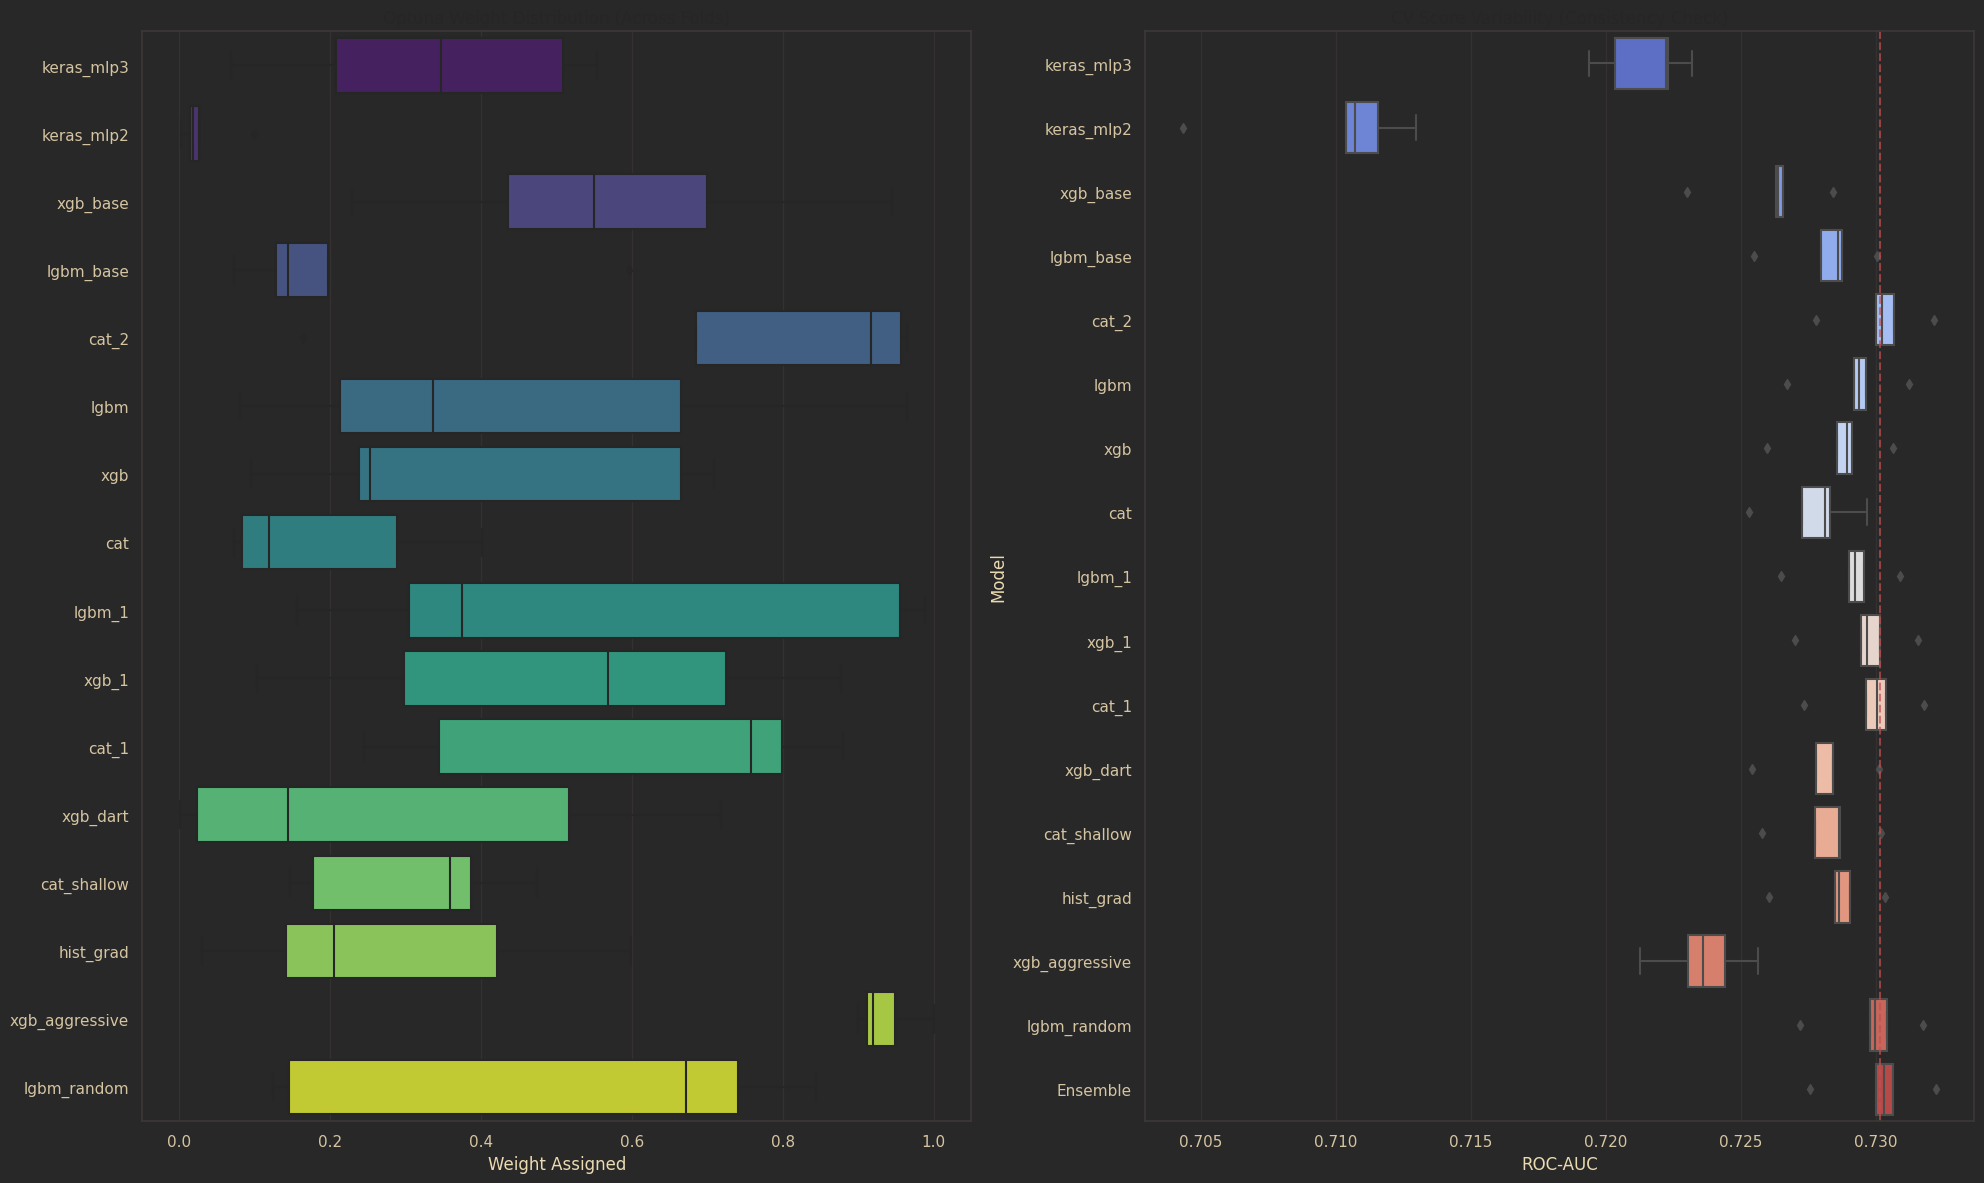


--- Average Optuna Weights ---
                Mean Weight   Std Dev
xgb_aggressive     0.935957  0.040202
cat_2              0.737711  0.340439
cat_1              0.605226  0.289031
xgb_base           0.572061  0.270264
lgbm_1             0.556141  0.388233
xgb_1              0.514229  0.314192
lgbm_random        0.505107  0.343973
lgbm               0.451968  0.359595
xgb                0.392328  0.277071
keras_mlp3         0.336990  0.203127
cat_shallow        0.309036  0.141009
xgb_dart           0.280734  0.320425
hist_grad          0.279178  0.228309
lgbm_base          0.227708  0.210646
cat                0.193115  0.145578
keras_mlp2         0.032055  0.038444


In [34]:
def plot_ensemble_diagnostics(score_dict, weights_perfold, oof_predss, y_train, base_models, ensemble_scores):
    
    # 1. Prepare Data
    model_names = list(base_models.keys())
    
    # 2. Text Report - The "Lift"
    mean_ens = np.mean(ensemble_scores)
    std_ens  = np.std(ensemble_scores)
    
    # Find best single model
    best_single_name = max(score_dict, key=lambda k: np.mean(score_dict[k]))
    best_single_score = np.mean(score_dict[best_single_name])
    
    lift = mean_ens - best_single_score
    
    print(f"==================================================")
    print(f"ENSEMBLE ROC-AUC:  {mean_ens:.5f} ± {std_ens:.5f}")
    print(f"BEST SINGLE ({best_single_name}): {best_single_score:.5f}")
    print(f"ENSEMBLE LIFT:    +{lift:.5f}")
    print(f"==================================================\n")

    # 3. Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(20, 12))
    
    # Plot A: Model Weights Boxplot (Stability Check)
    # Shows if Optuna consistently picks the same models or panics
    w_df = pd.DataFrame(weights_perfold, columns=model_names)
    sns.boxplot(data=w_df, ax=axes[0], orient='h', palette="viridis")
    axes[0].set_title("Optuna Weight Distribution (Across Folds)")
    axes[0].set_xlabel("Weight Assigned")
    
    # Plot B: CV Score Comparison
    # Shows the spread of scores for every model vs the Ensemble
    scores_df = pd.DataFrame(score_dict)
    scores_df['Ensemble'] = ensemble_scores # Add ensemble to comparison
    
    # Melt for seaborn
    scores_melt = scores_df.melt(var_name='Model', value_name='ROC-AUC')
    
    sns.boxplot(x='ROC-AUC', y='Model', data=scores_melt, ax=axes[1], orient='h', palette="coolwarm")
    axes[1].axvline(mean_ens, color='r', linestyle='--', alpha=0.7, label='Mean Ensemble')
    axes[1].set_title("CV Score Variability (Consistency Check)")
    
    plt.tight_layout()
    plt.show()

    # 4. Weight Summary Table
    print("\n--- Average Optuna Weights ---")
    mean_w = w_df.mean()
    std_w = w_df.std()
    summary = pd.DataFrame({'Mean Weight': mean_w, 'Std Dev': std_w})
    print(summary.sort_values('Mean Weight', ascending=False))

# --- RUN IT ---
plot_ensemble_diagnostics(score_dict, weights_perfold, oof_predss, y_train, base_models, ensemble_scores)

In [35]:
# results

In [36]:
mean_ens = np.mean(ensemble_scores)
std_ens  = np.std(ensemble_scores)
print(f"\nEnsemble ROC-AUC: {mean_ens:.5f} ± {std_ens:.5f}\n")

print("--- Base model CV ROC-AUC ---")
for name, scores in score_dict.items():
    if len(scores) == 0:
        continue
    print(f"{name:10s}: {np.mean(scores):.5f} ± {np.std(scores):.5f}")

print("\n--- Optuna Weights (mean ± std across folds) ---")
weights_arr = np.array(weights_perfold)   # shape: (folds, n_models)
mean_w = weights_arr.mean(axis=0)
std_w  = weights_arr.std(axis=0)

for name, mw, sw in zip(base_models.keys(), mean_w, std_w):
    print(f"{name:10s}: {mw:.5f} ± {sw:.5f}")


Ensemble ROC-AUC: 0.73015 ± 0.00150

--- Base model CV ROC-AUC ---
keras_mlp3: 0.72148 ± 0.00140
keras_mlp2: 0.70998 ± 0.00297
xgb_base  : 0.72613 ± 0.00174
lgbm_base : 0.72816 ± 0.00150
cat_2     : 0.73016 ± 0.00142
lgbm      : 0.72921 ± 0.00145
xgb       : 0.72864 ± 0.00151
cat       : 0.72772 ± 0.00144
lgbm_1    : 0.72903 ± 0.00143
xgb_1     : 0.72956 ± 0.00147
cat_1     : 0.72982 ± 0.00145
xgb_dart  : 0.72802 ± 0.00152
cat_shallow: 0.72820 ± 0.00144
hist_grad : 0.72849 ± 0.00139
xgb_aggressive: 0.72357 ± 0.00146
lgbm_random: 0.72982 ± 0.00149

--- Optuna Weights (mean ± std across folds) ---
keras_mlp3: 0.33699 ± 0.18168
keras_mlp2: 0.03206 ± 0.03439
xgb_base  : 0.57206 ± 0.24173
lgbm_base : 0.22771 ± 0.18841
cat_2     : 0.73771 ± 0.30450
lgbm      : 0.45197 ± 0.32163
xgb       : 0.39233 ± 0.24782
cat       : 0.19312 ± 0.13021
lgbm_1    : 0.55614 ± 0.34725
xgb_1     : 0.51423 ± 0.28102
cat_1     : 0.60523 ± 0.25852
xgb_dart  : 0.28073 ± 0.28660
cat_shallow: 0.30904 ± 0.12612
hist_

In [37]:
test_predss

array([0.47654054, 0.67624353, 0.77350405, ..., 0.52675944, 0.61013308,
       0.63960826])

In [38]:
df_sub = pd.read_csv('/kaggle/input/playground-series-s5e12/sample_submission.csv')

#proba_default   = test_predss       
#proba_dia = 1.0 - proba_default      
proba_dia = test_predss

print(proba_dia.min(), proba_dia.max())
print("Mean prob:", proba_dia.mean())

df_sub[target] = proba_dia
df_sub.to_csv("submission.csv", index=False)

0.04947167722651567 0.9859610434124554
Mean prob: 0.6025430530451114
